<a href="https://colab.research.google.com/github/146790g/VGG16-X-Ray-for-Pneumonia/blob/master/Xray_Fine%20Tuning%20VGG16_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深層学習 VGG16モデルのファイン・チューニング法を用いた肺炎Ｘ線画像の解析
#### COVID-19による新型肺炎のＸ線画像診断をAIにて行うことを目的とする
（背景）世界的なパンデミックにより新興国では医療崩壊が発生しており、診断を行う  
技師が不足している。そのため、AIによる診断が期待されている。

In [2]:
%tensorflow_version 2.x

In [3]:
%pwd
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls -lh '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data'

total 8.0K
drwx------ 2 root root 4.0K Jun 23 04:53 train
drwx------ 2 root root 4.0K Jun 23 04:53 validation


In [5]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import os
#import Pillow
#from PIL import Image
#import opencv
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, initializers

from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np




#num_train = 1000              # 訓練データの画像数
#num_validation = 1000          # テストデータの画像数

img_h, img_w = 150, 150
channels = 3
batch_size = 32               # ミニバッチのサイズ
train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data/train' # 訓練データのフォルダー
validation_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data/validation' # テストデータのフォルダー
result_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/results'        # VGG16の出力結果を保存するフォルダー
test_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/test1'
    


Using TensorFlow backend.


##第１章　訓練データ、テストデータの画像の視察的チェック
それぞれ、１２枚を選んできて、画像を視察的に確認する

['PNEUMONIA', 'NORMAL']
1343
3876
['IM-0530-0001.jpeg', 'IM-0509-0001-0001.jpeg', 'IM-0519-0001.jpeg', 'IM-0509-0001.jpeg', 'IM-0523-0001-0002.jpeg', 'IM-0513-0001.jpeg', 'IM-0514-0001.jpeg', 'IM-0528-0001.jpeg', 'IM-0531-0001.jpeg', 'IM-0540-0001.jpeg', 'IM-0532-0001.jpeg', 'IM-0533-0001.jpeg']
['person481_virus_983.jpeg', 'person482_bacteria_2043.jpeg', 'person482_bacteria_2044.jpeg', 'person482_bacteria_2045.jpeg', 'person483_bacteria_2046.jpeg', 'person483_virus_985.jpeg', 'person485_virus_988.jpeg', 'person482_virus_984.jpeg', 'person485_bacteria_2049.jpeg', 'person486_bacteria_2052.jpeg', 'person486_bacteria_2053.jpeg', 'person486_bacteria_2051.jpeg']
1044
1248
(1044,1248)


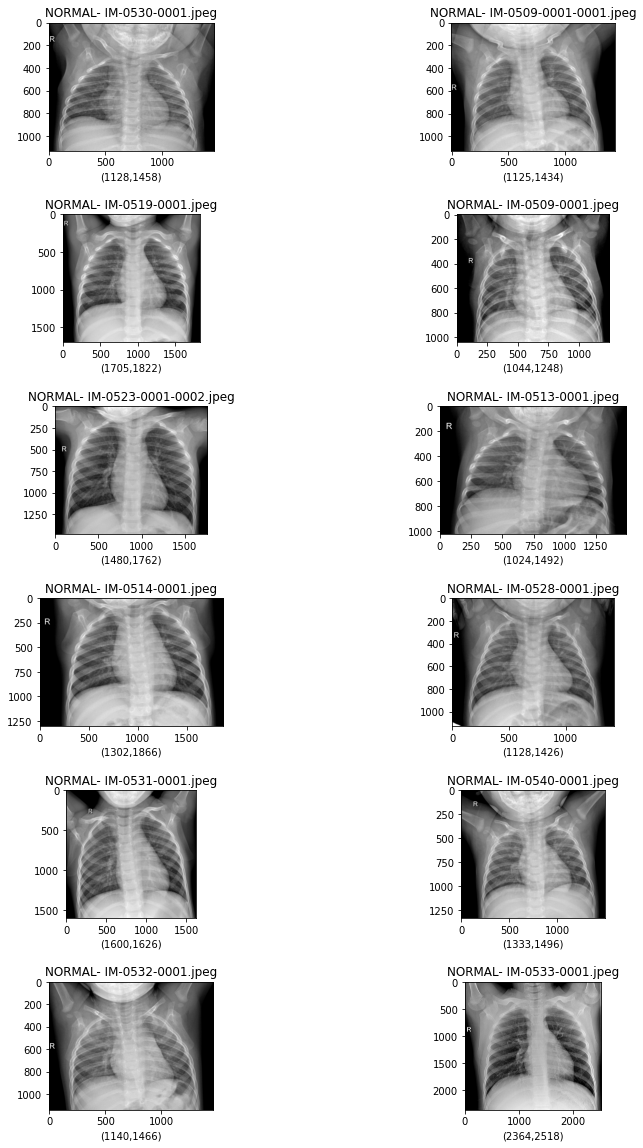

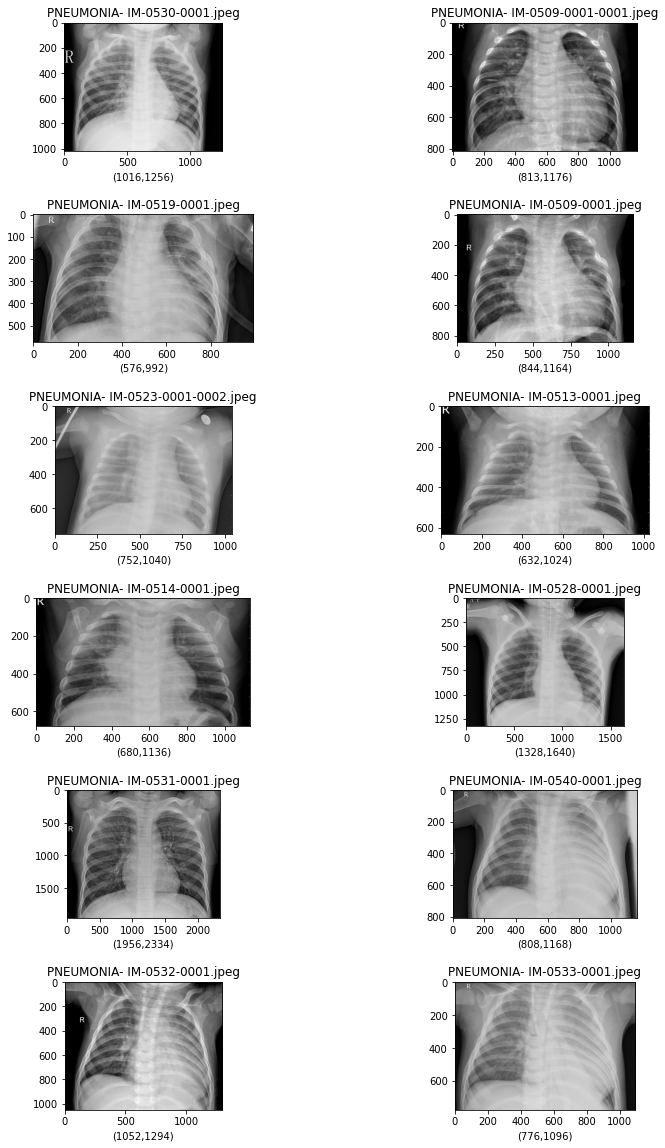

In [ ]:
import cv2

# !ls -lh '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data/train'

files=os.listdir(train_data_dir)
print(files)

normal_files = os.listdir(os.path.join(train_data_dir,'NORMAL'))
print(len(normal_files))
#1343
pneumonia_files = os.listdir(os.path.join(train_data_dir,'PNEUMONIA'))
print(len(pneumonia_files))
#3876
#total : 5219



normal_files = os.listdir(os.path.join(train_data_dir,'NORMAL'))[:12]
print(normal_files)

pneumonia_files = os.listdir(os.path.join(train_data_dir,'PNEUMONIA'))[:12]
print(pneumonia_files)

img = cv2.imread(os.path.join(train_data_dir,'NORMAL',normal_files[3]))
#type(img)
print(img.shape[0])
print(img.shape[1])
a='('+str(img.shape[0])+','+str(img.shape[1])+')'
print(a)
#cv2.imshow('image',img)

import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(12,20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(12):
  img = cv2.imread(os.path.join(train_data_dir,'NORMAL',normal_files[i]))
  ax = fig.add_subplot(6,2,i+1)
  ax.set_title('NORMAL'+'- '+normal_files[i])
  a='('+str(img.shape[0])+','+str(img.shape[1])+')'
  ax.set_xlabel(a)
  ax.imshow(img)
plt.show()

fig = plt.figure(figsize=(12,20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(12):
  img = cv2.imread(os.path.join(train_data_dir,'PNEUMONIA',pneumonia_files[i]))
  ax = fig.add_subplot(6,2,i+1)
  ax.set_title('PNEUMONIA'+'- '+normal_files[i])
  a='('+str(img.shape[0])+','+str(img.shape[1])+')'
  ax.set_xlabel(a)
  ax.imshow(img)
plt.show()


##第２章　訓練データ、テストデータの画像のサイズをチェック

肺炎患者の画像から、ランダムに３００枚を抽出してきて、その画像のサイズを
プロットする。

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import os
import pandas as pd
import pickleshare

%matplotlib inline



train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data/train'
pneumonia_files = os.listdir(os.path.join(train_data_dir,'PNEUMONIA'))
key=np.random.choice(range(len(pneumonia_files)),300)
pneumonia_files2=[pneumonia_files[s] for s in key]
print(pneumonia_files2)


x2=[]
y2=[]

for i in range(300):
  img = cv2.imread(os.path.join(train_data_dir,'PNEUMONIA',pneumonia_files2[i]))
  x2.append(img.shape[0])
  y2.append(img.shape[1])

pneumonia_image_size=pd.DataFrame([x2,y2])

result_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/results' 
pneumonia_image_size.to_pickle(os.path.join(result_dir,'pneumonia_image_size.pkl'))

['person1378_bacteria_3513.jpeg', 'person564_virus_1104.jpeg', 'person1488_bacteria_3887.jpeg', 'person1613_bacteria_4247.jpeg', 'person23_bacteria_94.jpeg', 'person1496_bacteria_3905.jpeg', 'person949_virus_1620.jpeg', 'person450_bacteria_1941.jpeg', 'person332_bacteria_1535.jpeg', 'person1107_virus_1832.jpeg', 'person66_bacteria_324.jpeg', 'person670_bacteria_2563.jpeg', 'person1205_bacteria_3157.jpeg', 'person61_bacteria_297.jpeg', 'person1303_bacteria_3267.jpeg', 'person832_bacteria_2743.jpeg', 'person1129_bacteria_3070.jpeg', 'person502_bacteria_2117.jpeg', 'person1674_bacteria_4437.jpeg', 'person749_bacteria_2652.jpeg', 'person1484_bacteria_3878.jpeg', 'person785_bacteria_2689.jpeg', 'person1713_bacteria_4530.jpeg', 'person688_virus_1281.jpeg', 'person974_virus_1649.jpeg', 'person1093_bacteria_3033.jpeg', 'person1052_bacteria_2986.jpeg', 'person1347_virus_2323.jpeg', 'person71_bacteria_351.jpeg', 'person294_bacteria_1381.jpeg', 'person466_bacteria_1987.jpeg', 'person1300_bacteria

健康成人の画像から、ランダムに３００枚を抽出してきて、その画像のサイズを
プロットする。

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pandas as pd
import pickleshare


%matplotlib inline

normal_files = os.listdir(os.path.join(train_data_dir,'NORMAL'))
print(len(normal_files))
#1343


train_data_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/data/train'
normal_files = os.listdir(os.path.join(train_data_dir,'NORMAL'))
key=np.random.choice(range(len(normal_files)),300)
normal_files2=[normal_files[s] for s in key]
print(normal_files2)

x=[]
y=[]

for i in range(300):
  img = cv2.imread(os.path.join(train_data_dir,'NORMAL',normal_files[i]))
  x.append(img.shape[0])
  y.append(img.shape[1])

print(x[:10])

normal_image_size=pd.DataFrame([x,y])
normal_image_size.to_pickle(os.path.join(result_dir,'normal_image_size.pkl'))


1343
['IM-0513-0001.jpeg', 'IM-0740-0001.jpeg', 'NORMAL2-IM-0383-0001.jpeg', 'NORMAL2-IM-0954-0001.jpeg', 'NORMAL2-IM-0832-0001.jpeg', 'NORMAL2-IM-1019-0001.jpeg', 'IM-0293-0001.jpeg', 'NORMAL2-IM-0967-0001.jpeg', 'NORMAL2-IM-0918-0001.jpeg', 'NORMAL2-IM-1102-0001.jpeg', 'NORMAL2-IM-0827-0001.jpeg', 'IM-0327-0001.jpeg', 'NORMAL2-IM-1141-0001.jpeg', 'NORMAL2-IM-0820-0001.jpeg', 'IM-0433-0001.jpeg', 'NORMAL2-IM-1301-0001.jpeg', 'IM-0537-0001.jpeg', 'IM-0445-0001.jpeg', 'IM-0549-0001-0002.jpeg', 'IM-0317-0001.jpeg', 'IM-0555-0001-0001.jpeg', 'IM-0705-0001.jpeg', 'IM-0670-0001.jpeg', 'IM-0629-0001-0002.jpeg', 'NORMAL2-IM-1322-0001.jpeg', 'NORMAL2-IM-0609-0001.jpeg', 'IM-0423-0001.jpeg', 'NORMAL2-IM-0473-0001.jpeg', 'NORMAL2-IM-0516-0001.jpeg', 'NORMAL2-IM-0521-0001.jpeg', 'IM-0650-0001.jpeg', 'NORMAL2-IM-1156-0001.jpeg', 'IM-0752-0001.jpeg', 'NORMAL2-IM-1183-0001.jpeg', 'NORMAL2-IM-1342-0001.jpeg', 'NORMAL2-IM-0687-0001.jpeg', 'IM-0444-0001.jpeg', 'IM-0404-0001.jpeg', 'IM-0551-0001.jpeg', 

186
2476
439
2572


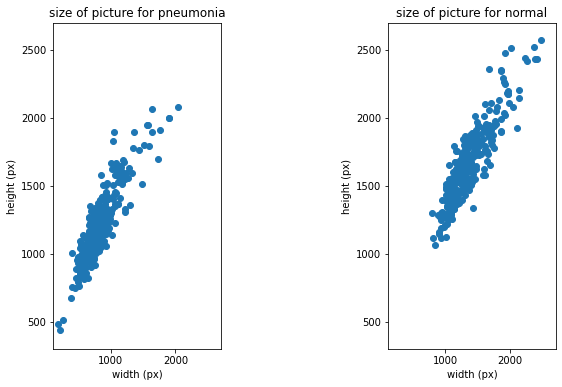

In [ ]:
result_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/results' 
df_pneumonia = pd.read_pickle(os.path.join(result_dir,'pneumonia_image_size.pkl'))
df_normal = pd.read_pickle(os.path.join(result_dir,'normal_image_size.pkl'))

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(9,6))
plt.subplots_adjust(wspace=1)
ax1=fig.add_subplot(1,2,1)

min1=min(df_pneumonia.iloc[0,].append(df_normal.iloc[0,]))
max1=max(df_pneumonia.iloc[0,].append(df_normal.iloc[0,]))
print(min1)
print(max1)

min2=min(df_pneumonia.iloc[1,].append(df_normal.iloc[1,]))
max2=max(df_pneumonia.iloc[1,].append(df_normal.iloc[1,]))
print(min2)
print(max2)

ax1.set_title('size of picture for pneumonia')
ax1.set_xlabel('width (px)')
ax1.set_ylabel('height (px)')
ax1.set_xlim(120,2700)
ax1.set_ylim(300,2700)
ax1.scatter(df_pneumonia.iloc[0,],df_pneumonia.iloc[1,])

ax2=fig.add_subplot(1,2,2)

ax2.set_title('size of picture for normal')
ax2.set_xlabel('width (px)')
ax2.set_ylabel('height (px)')
ax2.set_xlim(120,2700)
ax2.set_ylim(300,2700)
ax2.scatter(df_normal.iloc[0,],df_normal.iloc[1,])

plt.show()

### 【考察】
肺炎患者のX線画像の方が、健康成人のX線画像に比べて、画素数が低かった。
健康成人のＸ線画像は、横、縦ともに、１０００ピクセル以上であったが、
肺炎患者のＸ線画像は、１０００ピクセル以下が散見された。

画素数が多いほうが精度は上がるので、深層学習のモデルの可否の以前の問題として、
肺炎患者のＸ線画像の画素数と健康成人の画素数を揃えたほうがいいのではないかと
思う。

##第３章　VGG16とFC層を結合したモデルの構築
 ファインチューニング法を用いる  
VGG16モデルのうち、ブロック５を学習可能として、さらに、FC層は、独自で新規にモデルを構築する。

In [6]:
 ## VGG16モデルと学習済み重みを読み込む
vgg16_model = VGG16(include_top=False,        # 全結合層は層（FC）は読み込まない
                    weights='imagenet',       # ImageNetで学習した重みを利用
                    input_shape=(150, 150, 3) # 入力データの形状
                   )
# VGG16モデルのサマリを出力
print('VGG16モデルのサマリ')
vgg16_model.summary()

# VGG16のblock1_conv1からblock4_poolまでを凍結
# block5のみを学習可能にする
vgg16_model.trainable = True
set_trainable = False
for layer in vgg16_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:        
        layer.trainable = True
    else:
        layer.trainable = False
    
## 凍結後のサマリを出力
print('凍結後のサマリ')
vgg16_model.summary()

## VGG16モデルと独自のFC層を連結した計算モデルを構築
# Sequentialオブジェクトを生成
model = Sequential()

# VGG16モデルを追加
model.add(vgg16_model)
# Flatten層
model.add(Flatten())
# 全結合層
model.add(Dense(256,                 # ニューロン数は256
                activation='relu'    # 活性化関数はReLU
                ))
#第８層（出力層）
model.add(Dense(1, activation='sigmoid', name='sigmoid'))

# VGG16に独自のFC層を結合したモデルのサマリを出力
print('結合後のサマリ')
model.summary()    
     
     
     
  

58892288/58889256 [==============================] - 5s 0us/step
VGG16モデルのサマリ
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________

In [7]:
## モデルのコンパイル
# 最適化はRMSpropで行う
# 学習率を小さくしたのはファインチューニングを

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

In [ ]:
%pwd

'/content'

##第4章　データ拡張

In [8]:

img_h, img_w = 150, 150
channels = 3
batch_size = 32               # ミニバッチのサイズ
#train_data_dir = 'content/data/train' # 訓練データのフォルダー
#validation_data_dir = 'content/data/validation' # テストデータのフォルダー
#result_dir = 'results'        # VGG16の出力結果を保存するフォルダー  


## 訓練データを読み込むジェネレーターを生成
# データ拡張を行う
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,      # 40度の範囲でランダムに回転させる
    width_shift_range=0.2,  # 横サイズの0.2の割合でランダムに水平移動
    height_shift_range=0.2, # 縦サイズの0.2の割合でランダムに垂直移動
    horizontal_flip=True,   # 水平方向にランダムに反転、左右の入れ替え
    zoom_range=0.2,         # ランダムに拡大
    shear_range=0.2         # シアー変換をかける
)


# Dog vs Catの訓練データを生成するするジェネレーター
train_generator = train_datagen.flow_from_directory(
    train_data_dir,             # 訓練データのフォルダー
    target_size=(img_h, img_w), # 画像をリサイズ
    batch_size=batch_size,      # ミニバッチのサイズ
    class_mode='binary'         # 出力層は二値のラベルが必要
)


## テストデータを読み込むジェネレーターを生成
test_datagen = ImageDataGenerator(rescale=1.0 / 255)


# Dog vs Catのテストデータを生成するするジェネレーター
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,        # テストデータのフォルダー
    target_size=(img_h, img_w), # 画像をリサイズ
    batch_size=batch_size,      # ミニバッチのサイズ
    class_mode='binary'         # 出力層は二値のラベルが必要
)

Found 5218 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
type(train_generator)
print(train_generator.class_indices)
print(validation_generator.class_indices)


{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


## 第5章　Model Fitting

In [10]:
epochs=50
num_train = 5218
num_validation = 624

## 学習を行う

# 訓練データのジェネレーターのサイズ：164
print(len(train_generator))
# 訓練データの数をミニバッチのサイズで割った値：163
print(num_train//batch_size)
# テストデータのジェネレーターのサイズ：20
print(len(validation_generator))
# テストデータの数をミニバッチのサイズで割った値：19
print(num_validation//batch_size)

# モデルのファインチューニング
history = model.fit_generator(
    
    # 訓練データのジェネレーター
    generator=train_generator,
    # 各エポックにおけるステップ数として
    # 訓練データの数をミニバッチのサイズで割った値を指定
    steps_per_epoch=num_train//batch_size,
    # エポック数（学習回数）
    epochs=epochs,
    # テストデータのジェネレーター
    validation_data=validation_generator,
    # テストにおける各エポックにおけるステップ数として
    # テストデータの数をミニバッチのサイズで割った値を指定
    validation_steps=num_validation//batch_size
)

164
163
20
19
Epoch 1/50
 45/163 [=======>......................] - ETA: 32:04 - loss: 0.4038 - accuracy: 0.8083

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 82 could not be retrieved. It could be because a worker has died.
  UserWarning)


113/163 [===================>..........] - ETA: 13:45 - loss: 0.3007 - accuracy: 0.8678

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 116 could not be retrieved. It could be because a worker has died.
  UserWarning)


163/163 [==============================] - 2853s 18s/step - loss: 0.2746 - accuracy: 0.8797 - val_loss: 0.4396 - val_accuracy: 0.8931
Epoch 2/50
163/163 [==============================] - 109s 671ms/step - loss: 0.1667 - accuracy: 0.9339 - val_loss: 0.2454 - val_accuracy: 0.9172
Epoch 3/50
163/163 [==============================] - 109s 671ms/step - loss: 0.1528 - accuracy: 0.9410 - val_loss: 0.1605 - val_accuracy: 0.9088
Epoch 4/50
163/163 [==============================] - 108s 660ms/step - loss: 0.1355 - accuracy: 0.9491 - val_loss: 0.1379 - val_accuracy: 0.9189
Epoch 5/50
163/163 [==============================] - 107s 657ms/step - loss: 0.1320 - accuracy: 0.9520 - val_loss: 0.4184 - val_accuracy: 0.8970
Epoch 6/50
163/163 [==============================] - 107s 657ms/step - loss: 0.1250 - accuracy: 0.9518 - val_loss: 0.3260 - val_accuracy: 0.9223
Epoch 7/50
163/163 [==============================] - 106s 653ms/step - loss: 0.1144 - accuracy: 0.9574 - val_loss: 0.4908 - val_accurac

In [17]:
result_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/results'


with open(os.path.join(result_dir,'xrayvgg16model.json'),'w') as json_file:
  json_file.write(model.to_json())

#model parameter save
model.save_weights(os.path.join(result_dir,'xrayvgg16parameter.h5'))


# model save
model.save(os.path.join(result_dir,'xrayvgg16model_parameter.h5'))

import pandas as pd

df_history=pd.DataFrame(history.history)
result_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/results' 
df_history.to_pickle(os.path.join(result_dir,'history.pkl'))

In [14]:
type(history)
history.history
type(history.history)

dict

In [ ]:
np.mean(history.history['accuracy'][45:50])

0.9821657

In [ ]:
np.mean(history.history['val_accuracy'][45:50])

0.9351351380348205

##【考察】
epochが、46番から50番までの精度の平均値を算出すると、  
訓練データ：精度：98.2 ％  
テストデータ：精度：93.5％  
であった。
 このことから、このVGG16モデルのファインチューニング法により構築されたモデルは、十分に妥当であると考えられる。

##第６章　モデルの評価

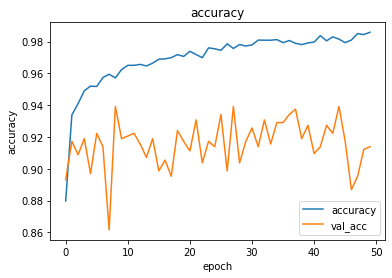

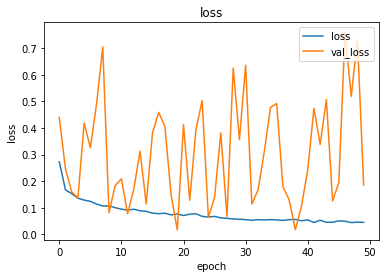

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)

In [21]:
predictions > 0.6
type(predictions)
predictions.shape

(624, 1)

##第７章　Visual Predictive Check

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
import numpy as np
from keras.models import load_model


def predictXrayVGG16(file):
    '''
    画像を読み込んでVGG16とFC層で予測する
    file：対象の画像のディレクトリ
    '''
    img_h, img_w = 150, 150
    channels = 3
    
    model=load_model(os.path.join(result_dir,'xrayvgg16model_parameter.h5'))

    model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics=['accuracy'])
    
    filename=file
    
    img = image.load_img(
        filename,
        target_size=(img_h, img_w))
    
    # (height, width, channel)の3階テンソルに変換
    x = image.img_to_array(img)
    # 4階テンソルに変換
    x = np.expand_dims(x, axis=0)
    # RGB値を0.0～1.0の範囲に変換
    x = x / 255.0
    
    # モデルに入力して予測する
    # 入力は1枚の画像なのでx[0]のみ
    pred = model.predict(x[0:])
    # 0.5以上はイヌ、0.5より小さければネコ
    if pred >= 0.5:
        print(pred, '-> 肺炎です。')
    else:
        print(pred, '-> 正常です。')

    # 画像を描画
    img = mpimg.imread(file)
    plt.axis('off')
    imgplot = plt.imshow(img)
    plt.show()

### 健康成人由来のX線画像に対して、先ほど構築したモデルで予測する。
『正常です。』と表示されていれば、正解。

8
['NORMAL2-IM-1427-0001.jpeg', 'NORMAL2-IM-1438-0001.jpeg', 'NORMAL2-IM-1437-0001.jpeg', 'NORMAL2-IM-1431-0001.jpeg', 'NORMAL2-IM-1442-0001.jpeg', 'NORMAL2-IM-1436-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-1440-0001.jpeg']
[[0.22303662]] -> 正常です。


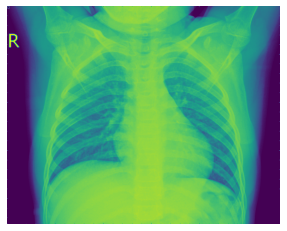

[[0.8928333]] -> 肺炎です。


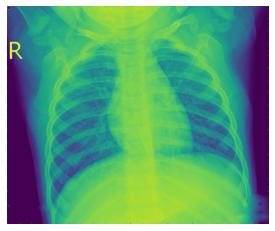

[[0.00811505]] -> 正常です。


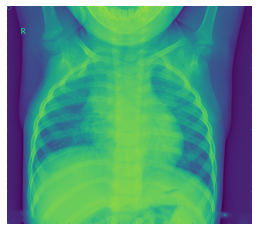

[[0.38076383]] -> 正常です。


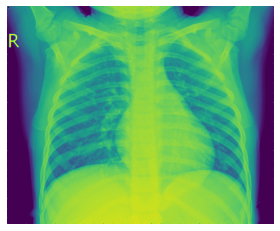

[[0.00133932]] -> 正常です。


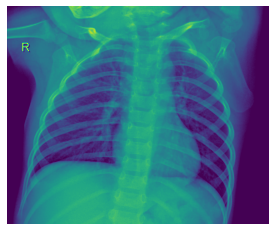

[[0.3298578]] -> 正常です。


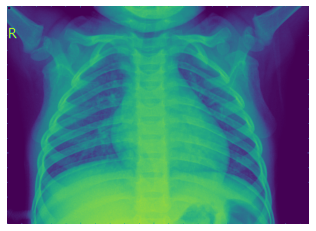

[[0.43739182]] -> 正常です。


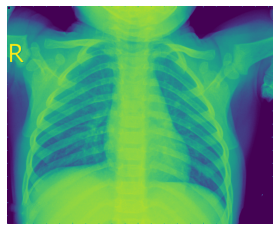

[[0.00060246]] -> 正常です。


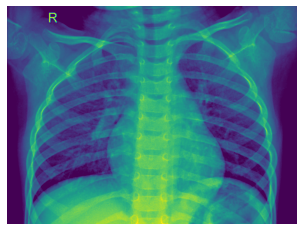

In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

test_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/test1'
normal_files=os.listdir(os.path.join(test_dir,'NORMAL'))
print(len(normal_files))
print(normal_files)

%matplotlib inline


for i in range(8):
  predictXrayVGG16(os.path.join(test_dir,'NORMAL',normal_files[i]))




### 肺炎患者由来のX線画像に対して、先ほど構築したモデルで予測する。
『肺炎です。』と表示されていれば、正解。

8
['person1946_bacteria_4874.jpeg', 'person1946_bacteria_4875.jpeg', 'person1949_bacteria_4880.jpeg', 'person1954_bacteria_4886.jpeg', 'person1950_bacteria_4881.jpeg', 'person1951_bacteria_4882.jpeg', 'person1952_bacteria_4883.jpeg', 'person1947_bacteria_4876.jpeg']
[[0.9999491]] -> 肺炎です。


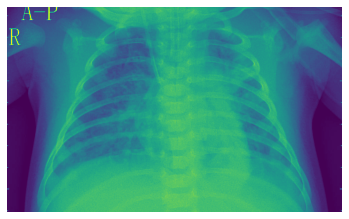

[[0.9995931]] -> 肺炎です。


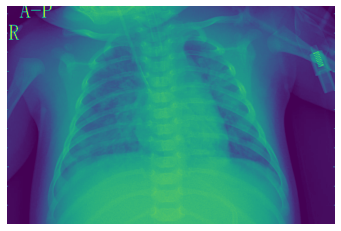

[[0.7041083]] -> 肺炎です。


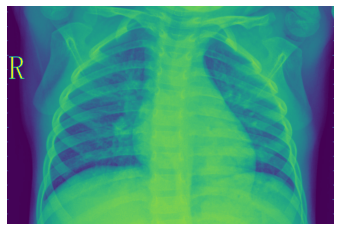

[[0.9999999]] -> 肺炎です。


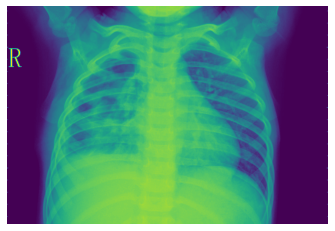

[[0.9932161]] -> 肺炎です。


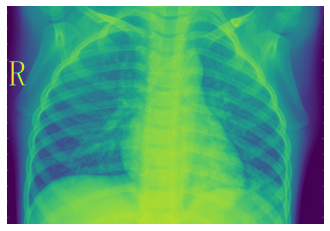

[[0.9999968]] -> 肺炎です。


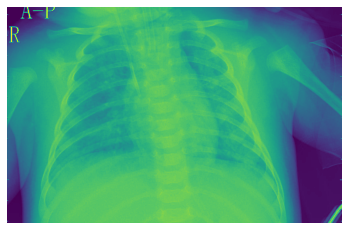

[[0.99959785]] -> 肺炎です。


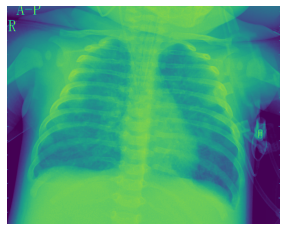

[[0.90509737]] -> 肺炎です。


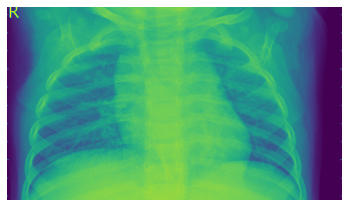

In [20]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

test_dir = '/content/gdrive/My Drive/Colab Notebooks/Xray for Penumonia/test1'
pneumonia_files=os.listdir(os.path.join(test_dir,'PNEUMONIA'))
print(len(pneumonia_files))
print(pneumonia_files)

%matplotlib inline


for i in range(len(pneumonia_files)):
  predictXrayVGG16(os.path.join(test_dir,'PNEUMONIA',pneumonia_files[i]))

###【考察】  
肺炎患者由来のＸ線画像については、すべて正解であった。健康成人由来のＸ線画像については、1枚のみ、誤った。
しかし、その画像についても、肺炎である確率は、８９％としており、他の肺炎患者由来のＸ線画像に比べても、確率が低く算出されいた。